In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# Transformation standard
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Datasets
train_dataset = datasets.MNIST(root="data/raw", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data/raw", train=False, download=True, transform=transform)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [3]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST_CNN().to(device)

In [5]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [6]:
epochs = 5

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch}: Loss={running_loss/total:.4f}, Accuracy={100*correct/total:.2f}%")

Epoch 1: Loss=0.1369, Accuracy=95.80%
Epoch 2: Loss=0.0450, Accuracy=98.61%
Epoch 3: Loss=0.0300, Accuracy=99.05%
Epoch 4: Loss=0.0217, Accuracy=99.30%
Epoch 5: Loss=0.0174, Accuracy=99.42%


In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 99.00%


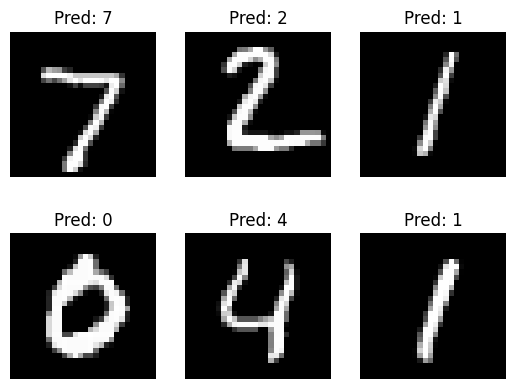

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data = example_data.to(device)
output = model(example_data)

_, preds = torch.max(output, 1)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0].cpu(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis('off')
plt.show()